V-shaped transits can be caused grazing planets, or by eclipsing binaries whose light contaminates the mask of the target star. The probability for the latter can be estimated using high-resolution imaging and radial velocity measurements.

The sensitivity of BLS to V-shaped transits is reduced by ~50%, as the filter mismatch is much larger compared to more box-like transit shapes. This is problematic for small planets, where the signal is sufficient for detection, but the planet is not apparent in the BLS power spectrum. These planets can efficiently be detected by setting TLS up for V-shaped transits.

We start our tutorial by downloading and detrending the data for WASP-75 [(Clark+ 2018)](https://doi.org/10.1088/1538-3873/aaa33e), a known grazing hot Jupiter.

In [1]:
import numpy
import scipy
import everest
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.CRITICAL)

EPIC_ID = 206154641
star = everest.Everest(EPIC_ID)
t = star.time
y = star.fcor
t = numpy.delete(star.time, star.badmask)
y = numpy.delete(star.fcor, star.badmask)
t = numpy.array(t[~numpy.isnan(y)], dtype='float32')
y = numpy.array(y[~numpy.isnan(y)], dtype='float32')

trend = scipy.signal.medfilt(y, 25)
y_filt = y / trend
y_filt = sigma_clip(y_filt, sigma_upper=3, sigma_lower=99)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("Flux (electrons per sec)")
ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("Time (days)")
ax.set_ylabel("Flux");

/home/michael/.local/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 206154641.


Now the crucial step is to specify a grazing model. For comparison, we also run a steep trapezoid, approximating a classical BLS search:

Transit Least Squares TLS 1.0.7 (04 January 2019)
Creating model cache for 35 durations
Searching 3190 data points, 7226 periods from 0.602 to 34.581 days, using all 8 CPU threads


100%|██████████| 7226/7226 periods | 00:14<00:00  
  0%|          | 8/2953 [00:00<00:36, 79.75it/s]

Searching for best T0 for period 2.48470


100%|██████████| 2953/2953 [00:01<00:00, 1649.42it/s]


Transit Least Squares TLS 1.0.7 (04 January 2019)
Creating model cache for 35 durations
Searching 3190 data points, 7226 periods from 0.602 to 34.581 days, using all 8 CPU threads


100%|██████████| 7226/7226 periods | 00:14<00:00  
  5%|▌         | 168/3190 [00:00<00:01, 1673.86it/s]

Searching for best T0 for period 2.48470


100%|██████████| 3190/3190 [00:01<00:00, 1714.29it/s]


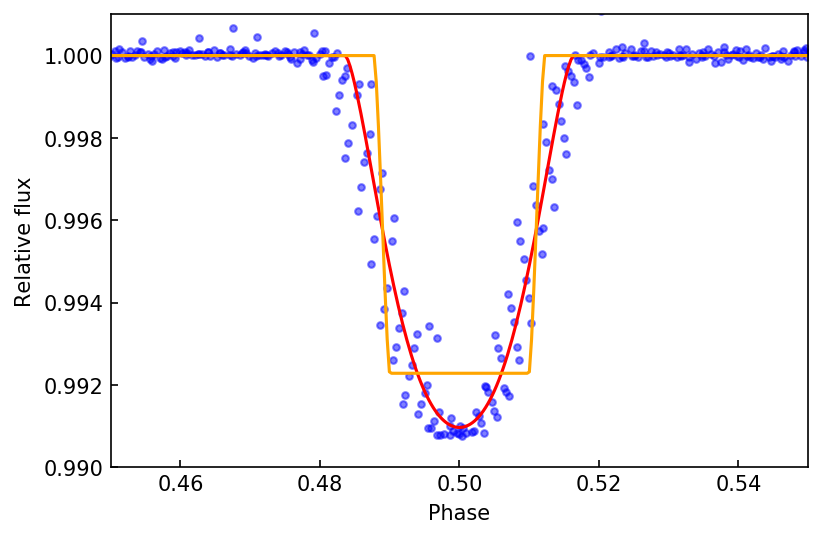

In [2]:
from transitleastsquares import transitleastsquares
model_grazing = transitleastsquares(t, y_filt)
results_grazing = model_grazing.power(
    transit_template='grazing')

model_box = transitleastsquares(t, y_filt)
results_box= model_box.power(
    transit_template='box')

from matplotlib import rcParams; rcParams["figure.dpi"] = 150
ax.get_yaxis().set_tick_params(which='both', direction='out')
ax.get_xaxis().set_tick_params(which='both', direction='out')

plt.plot(
    results_grazing.model_folded_phase,
    results_grazing.model_folded_model,
    color='red')
plt.scatter(
    results_grazing.folded_phase,
    results_grazing.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)

plt.plot(
    results_box.model_folded_phase,
    results_box.model_folded_model,
    color='orange')

plt.xlim(0.45, 0.55)
plt.ylim(0.99, 1.001)
plt.xlabel('Phase')
plt.ylabel('Relative flux');

The box-shaped transit template is, as expected, a much worse fit. But how much does this mismatch actually affect detection efficiency? For such a deep transit, the difference is irrelevant. But for transits with lower SNR, it is useful to know the difference.

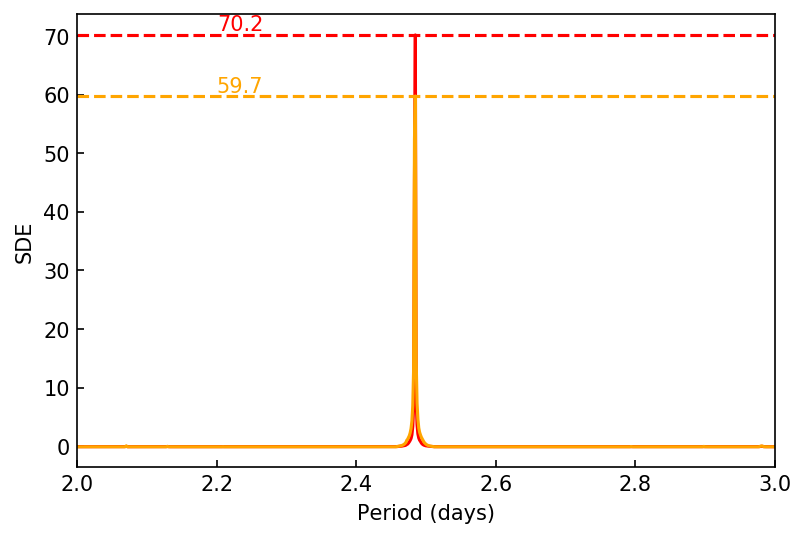

In [3]:
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results_grazing.periods, results_grazing.power, color='red')
plt.plot(results_box.periods, results_box.power, color='orange')
plt.plot((2, 3), (results_grazing.SDE, results_grazing.SDE), color='red', linestyle='dashed')
plt.plot((2, 3), (results_box.SDE, results_box.SDE), color='orange', linestyle='dashed')
plt.text(2.2, results_box.SDE*1.01, format(results_box.SDE, '.1f'), color='orange')
plt.text(2.2, results_grazing.SDE*1.01, format(results_grazing.SDE, '.1f'), color='red')
plt.xlim(2, 3);

So the difference in signal detection efficiency is ~70/60 ~ 17%. For a true box and BLS' binning, it is a few percent more than that. Of course, the actual difference in other cases depends on many factors, such as noise levels and signal shapes. But the 20% (order of magnitude) difference is what one should expect.